In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

#import dask.dataframe as dd

from datetime import datetime

In [2]:
import keras 

from keras.preprocessing import sequence
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, LeakyReLU
from keras.layers import Embedding
from keras.layers import Concatenate, Flatten, Reshape, Lambda
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from keras.utils import plot_model
from keras import backend as K

from keras.datasets import imdb

Using TensorFlow backend.


In [3]:
#K.tensorflow_backend._get_available_gpus()

Helpful links:
1. Inverse of np.log1p: https://stackoverflow.com/questions/50049891/what-is-the-inverse-of-numpys-log1p
2. Building parallel keras model: https://stackoverflow.com/questions/43151775/how-to-have-parallel-convolutional-layers-in-keras
3. How to make parallel keras models: https://datascience.stackexchange.com/questions/39407/how-to-make-two-parallel-convolutional-neural-networks-in-keras
4. 2 parallel keras layers: https://stackoverflow.com/questions/51546075/two-parallel-conv2d-layers-keras
5. Setting up Conv1D and LSTM: https://stackoverflow.com/questions/51344610/how-to-setup-1d-convolution-and-lstm-in-keras
6. Take average of LSTM hidden states using Lambda: https://stackoverflow.com/questions/51479940/average-channels-of-convolutional-layer-keras
7. Preparing categorical variable for neural networks: https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
8. Tutorial for using keras for time series (no generators used): https://medium.com/@jdwittenauer/deep-learning-with-keras-structured-time-series-37a66c6aeb28


In [4]:
train = pd.read_csv("gs://123test_bucket/train.csv")

In [5]:
reading = train['meter_reading']
train['meter_reading'] = np.log1p(train['meter_reading'])

scaler1 = MinMaxScaler()
train['meter_reading'] = scaler1.fit_transform(X=np.reshape(train['meter_reading'].values, (-1, 1))).reshape(len(train),)

In [6]:
train['meter_reading'].mean()

0.2452794762030242

#### Reading Test Data

In [7]:
test = pd.read_csv("gs://123test_bucket/test.csv")

In [8]:
train.timestamp = pd.to_datetime(train.timestamp)
test.timestamp = pd.to_datetime(test.timestamp)

In [9]:
len(train), len(test)

(20216100, 41697600)

#### Reading Weather and Meta Data

In [10]:
weather_train = pd.read_csv("gs://123test_bucket/weather_train.csv")
weather_test = pd.read_csv("gs://123test_bucket/weather_test.csv")
meta = pd.read_csv("gs://123test_bucket/building_metadata.csv")

In [11]:
weather_train.timestamp = pd.to_datetime(weather_train.timestamp)
weather_test.timestamp = pd.to_datetime(weather_test.timestamp)

In [12]:
train = pd.merge(pd.merge(train, meta, on='building_id', how='left'),
                 weather_train,
                 on=['site_id', 'timestamp'],
                 how='inner')
test = pd.merge(pd.merge(test, meta, on='building_id', how='left'),
                 weather_test,
                 on=['site_id', 'timestamp'],
                 how='left')

In [13]:
train['month'] = train.timestamp.dt.month
train['dayofweek'] = train.timestamp.dt.dayofweek
train['hour'] = train.timestamp.dt.hour

test['month'] = test.timestamp.dt.month
test['dayofweek'] = test.timestamp.dt.dayofweek
test['hour'] = test.timestamp.dt.hour

#### Adding Weekday/Weekend Flag

In [14]:
train['weekday'] = 0
test['weekday'] = 0
weekday_map = {0:0,
               1:0,
               2:0,
               3:0,
               4:0,
               5:1,
               6:1}
train['weekday'] = train['dayofweek'].map(weekday_map)
test['weekday'] = test['dayofweek'].map(weekday_map)

In [15]:
test.loc[40525*1024: (40525*1024)+1024]

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,dayofweek,hour,weekday
41497600,41497600,1337,1,2018-12-31 20:00:00,15,Office,14744,1910.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20,0
41497601,41497601,1337,2,2018-12-31 20:00:00,15,Office,14744,1910.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20,0
41497602,41497602,1338,0,2018-12-31 20:00:00,15,Education,31415,1912.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20,0
41497603,41497603,1338,2,2018-12-31 20:00:00,15,Education,31415,1912.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20,0
41497604,41497604,1339,0,2018-12-31 20:00:00,15,Education,140488,1961.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41498620,41498620,144,0,2017-01-18 09:00:00,1,Office,57673,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9,0
41498621,41498621,144,3,2017-01-18 09:00:00,1,Office,57673,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9,0
41498622,41498622,145,0,2017-01-18 09:00:00,1,Office,14219,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9,0
41498623,41498623,145,3,2017-01-18 09:00:00,1,Office,14219,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9,0


#### Scaling Data

In [16]:
train = train.fillna(0)
test = test.fillna(0)

In [17]:
scaler2 = MinMaxScaler()
num_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'square_feet', 'floor_count']
scaler2.fit(train[num_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
train[num_cols] = scaler2.transform(train[num_cols])
test[num_cols] = scaler2.transform(test[num_cols])

#### Joining Weather, Metadata with load data

In [19]:
len(train), len(test)

(20125605, 41697600)

In [20]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month', 'dayofweek', 'hour', 'weekday'],
      dtype='object')

In [21]:
train.head(2)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,dayofweek,hour,weekday
0,0,0,2016-01-01,0.0,0,Education,0.008173,2008.0,0.0,0.708279,0.666667,0.900164,0.002907,0.975323,0.0,0.0,1,4,0,0
1,1,0,2016-01-01,0.0,0,Education,0.002786,2004.0,0.0,0.708279,0.666667,0.900164,0.002907,0.975323,0.0,0.0,1,4,0,0


#### Encoding Categorical Variables

In [22]:
enc = OrdinalEncoder()
cat_cols = ['site_id', 'hour', 'dayofweek', 'month', 'primary_use', 'year_built']
other_cols = ['building_id', 'meter']
enc.fit(train[cat_cols])


OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [23]:
train[cat_cols] = enc.transform(train[cat_cols])
test[cat_cols] = enc.transform(test[cat_cols])

#### Random ID selection

Using 30% of the data as validation data. If more data is needed, we should consider adding data by randomly selecting buildings.

In [24]:
ids = train['building_id'].unique()

In [25]:
# keeping 80% of the ids
len_sub = round(len(ids)*0.80)
ids_sub = np.random.choice(ids, len_sub, replace = False)

In [26]:
# 0.3 represents the percentage of data that is kept for validation
len_val = round(len(ids_sub)*0.3)

In [27]:
ids_val = np.random.choice(ids_sub, len_val, replace = False)

In [28]:
ids_train = np.setdiff1d(ids_sub,ids_val)

In [29]:
assert len(ids_val)+len(ids_train)==len(ids_sub)

#### Applying TimeseriesGenerator to the ASHRAE training data

Once difference between the example above, and our situation is that we have multiple timeseries, for each building and each meter in the building. So, we will be required to modify the code a little bit.

Below, we check how many meters exist in the dataset.

In [30]:
len(train[['building_id', 'meter']].drop_duplicates()), len(test[['building_id', 'meter']].drop_duplicates())

(2380, 2380)

The code below has been taken from this stackoverflow answer with some modifications:
https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id/55118459#55118459

The modification is basically that once we subset the data for building ID, it is then subset for meter type also.

Further reading about modifying keras generator classes can be found below:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

#### Defining Generators

In [31]:
num_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'square_feet', 'floor_count'] 

cat_names = cat_cols + other_cols + ['weekday']

#new_cat_names = list(enc.get_feature_names(cat_names))

#col_names = num_cols + new_cat_names

In [32]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, dt, num_cols, cat_names, batch_size = 10):
        self.batch_size = batch_size
        self.len = len(dt)//batch_size
        self.dt = dt[num_cols + cat_names + ['meter_reading']]
        self.num_cols = num_cols
        self.cat_names = cat_names

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        index_start = index*self.batch_size
        index_end = index_start+self.batch_size
        adf = self.dt[index_start:index_end]
        return [adf[x] for x in cat_names]+[adf[num_cols]], adf['meter_reading']

In [33]:
class TestDataGenerator(keras.utils.Sequence):
    def __init__(self, dt, num_cols, cat_names, batch_size = 10):
        self.batch_size = batch_size
        self.len = round(len(dt)/batch_size)
        self.dt = dt[num_cols + cat_names]
        self.num_cols = num_cols
        self.cat_names = cat_names

    def __len__(self):
        return self.len+1

    def __getitem__(self, index):
        index_start = index*self.batch_size
        index_end = index_start+self.batch_size
        adf = self.dt[index_start:index_end]
        return [adf[x] for x in cat_names]+[adf[num_cols]]

#### Training and Validation Generators

In [100]:
# Test
batch_size = 100*1024#1024+512
train_gen = DataGenerator(train[train['building_id'].isin(ids_train)], 
                          num_cols=num_cols, 
                          cat_names=cat_names,
                          batch_size=batch_size)
val_gen = DataGenerator(train[train['building_id'].isin(ids_val)],
                        num_cols=num_cols, 
                        cat_names=cat_names,
                        batch_size=batch_size)   


In [101]:
check1 = train_gen[0]
check2 = val_gen[0]

In [102]:
len(check1[0]), len(check2[0]), len(cat_names)+1

(10, 10, 10)

#### Loss Function - Root Mean Square

In [103]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#### Embeddings NN

1. https://towardsdatascience.com/decoded-entity-embeddings-of-categorical-variables-in-neural-networks-1d2468311635
2. https://medium.com/@satnalikamayank12/on-learning-embeddings-for-categorical-data-using-keras-165ff2773fc9
3. https://github.com/mayanksatnalika/ipython/blob/master/embeddings%20project/cycle_sharing/entity_embeddings_regression.ipynb

In [104]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month', 'dayofweek', 'hour', 'weekday'],
      dtype='object')

In [105]:
len(train.columns)

20

In [106]:
len(cat_names), len(num_cols)

(9, 9)

In [111]:
models = []
inputs = []
act = 'relu'
n_num_cols = len(num_cols)


for categorical_var in cat_names:
    model = Sequential()
    model.reset_states()
    no_of_unique_cat  = train[categorical_var].nunique()
    embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
    embedding_size = int(embedding_size)
    input1 = Input(shape=(1,))
    model = Embedding(no_of_unique_cat+1,embedding_size)(input1)
    model = Reshape(target_shape=(embedding_size,))(model)
    models.append(model)
    inputs.append(input1)
    
input1 = Input(shape=(n_num_cols,))
model_rest = Dense(65, activation=act)(input1)
models.append(model_rest)
inputs.append(input1)

m1 = keras.layers.concatenate(models, axis = 1)
m1 = Dense(50, activation=act)(m1)
m1 = Dropout(0.5)(m1)
m1 = Dense(5, activation=act)(m1)
m1 = LeakyReLU(alpha=0.1)(m1)
m1 = Dropout(0.2)(m1)
m1 = Dense(1, activation='sigmoid')(m1)

model3 = Model(inputs = inputs, outputs = m1)

opt = keras.optimizers.RMSprop(clipnorm=1.)

model3.compile(loss=root_mean_squared_error, optimizer=opt, metrics=['mse', 'mae', 'mape'])

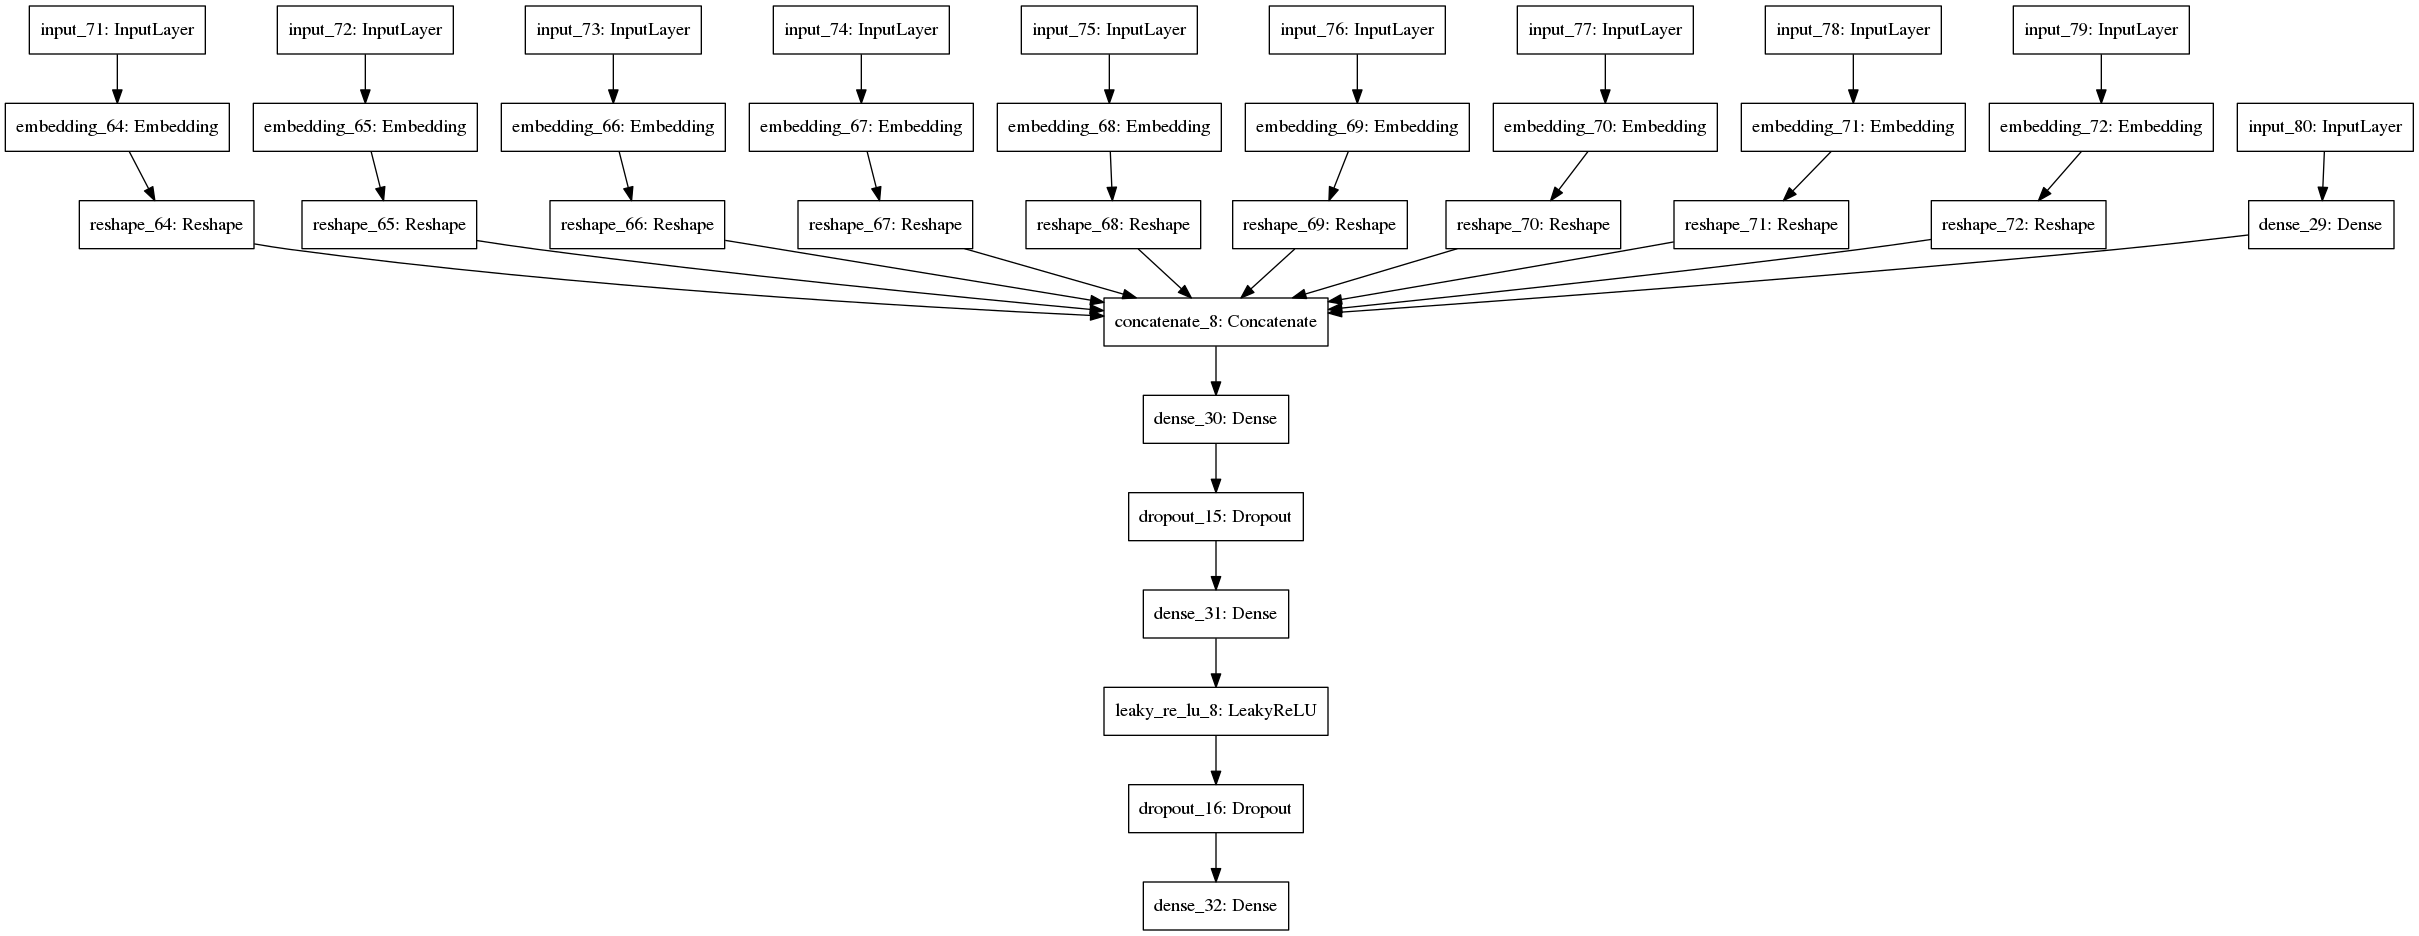

In [112]:
plot_model(model3)

In [113]:
model3.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_73 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

In [114]:
epochs = 20#TODO: change it back to 5
workers = 10
model3.fit_generator(generator=train_gen,
                    validation_data=val_gen, epochs=epochs, 
                    use_multiprocessing=True, workers = workers)

/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
108/108 [==============================] - 14s 129ms/step - loss: 0.1328 - mse: 0.0186 - mae: 0.1025 - mape: 22971610.0000 - val_loss: 0.1233 - val_mse: 0.0149 - val_mae: 0.0942 - val_mape: 22527394.0000
Epoch 2/20
108/108 [==============================] - 12s 110ms/step - loss: 0.1124 - mse: 0.0127 - mae: 0.0829 - mape: 20176904.0000 - val_loss: 0.1205 - val_mse: 0.0146 - val_mae: 0.0935 - val_mape: 22303164.0000
Epoch 3/20
Epoch 2/20
108/108 [==============================] - 12s 113ms/step - loss: 0.1065 - mse: 0.0114 - mae: 0.0770 - mape: 19922620.0000 - val_loss: 0.1160 - val_mse: 0.0142 - val_mae: 0.0931 - val_mape: 21156376.0000
Epoch 4/20
108/108 [==============================] - 13s 116ms/step - loss: 0.1012 - mse: 0.0103 - mae: 0.0722 - mape: 19324472.0000 - val_loss: 0.1137 - val_mse: 0.0140 - val_mae: 0.0932 - val_mape: 20223950.0000
Epoch 5/20
108/108 [==============================] - 12s 115ms/step - loss: 0.0960 - mse: 0.0093 - mae: 0.0679 - mape: 18412624.

/home/jupyter/.local/lib/python3.5/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/108 [==============================] - 12s 115ms/step - loss: 0.0862 - mse: 0.0075 - mae: 0.0595 - mape: 15370393.0000 - val_loss: 0.1103 - val_mse: 0.0137 - val_mae: 0.0904 - val_mape: 18373638.0000
Epoch 8/20
108/108 [==============================] - 12s 115ms/step - loss: 0.0830 - mse: 0.0069 - mae: 0.0568 - mape: 14120047.0000 - val_loss: 0.1098 - val_mse: 0.0137 - val_mae: 0.0910 - val_mape: 17303166.0000
Epoch 9/20
108/108 [==============================] - 12s 115ms/step - loss: 0.0805 - mse: 0.0065 - mae: 0.0547 - mape: 13261927.0000 - val_loss: 0.1083 - val_mse: 0.0138 - val_mae: 0.0909 - val_mape: 17010582.0000
Epoch 10/20
108/108 [==============================] - 12s 114ms/step - loss: 0.0785 - mse: 0.0062 - mae: 0.0528 - mape: 12555096.0000 - val_loss: 0.1083 - val_mse: 0.0140 - val_mae: 0.0917 - val_mape: 16006089.0000
Epoch 11/20
108/108 [==============================] - 12s 115ms/step - loss: 0.0769 - mse: 0.0060 - mae: 0.0512 - mape: 11975608.0000 - val_loss: 0.1

1. Dense(64) for model_rest, epoch 1: loss=0.0656, val_loss=0.1382, val_loss increased
2. Replacing the Dense(64) for model_rest with Dense(24), epoch 1: loss: 0.0648, val_loss: 0.1481, val_loss increased

In [118]:
val_test_gen = TestDataGenerator(train[train['building_id'].isin(ids_val)], 
                                 num_cols=num_cols, 
                                cat_names=cat_names,
                                batch_size=batch_size)
print(len(val_test_gen))

val_test_res = model3.predict_generator(generator=val_test_gen, workers=12, use_multiprocessing=True)
val_test_res_og = pd.Series(np.expm1(scaler1.inverse_transform(val_test_res)).reshape(val_test_res.shape[0],))

x = []
for i in range(len(val_test_gen)):
    x.append(val_gen[i][1].values)

val_test_y = pd.Series(np.expm1(scaler1.inverse_transform(np.concatenate(x, axis=0).reshape(1, -1))).reshape(val_test_res.shape[0],))

print(len(val_test_y) == len(val_test_res_og))

48
True


In [119]:
print("Error: " +str({np.sqrt(np.mean(np.square(val_test_res_og - val_test_y)))}))

Error: {312372.7293354047}


#### Defining Function for Prediction - Method 1

In [120]:
test_gen = TestDataGenerator(test, num_cols=num_cols, 
                        cat_names=cat_names,
                        batch_size=batch_size)

In [121]:
len(test_gen)

408

In [122]:
cat_cols

['site_id', 'hour', 'dayofweek', 'month', 'primary_use', 'year_built']

In [62]:
#enc.categories_

In [63]:
#test.loc[40525*1024: (40525*1024)+1024]#.dt.month

In [123]:
result = model3.predict_generator(generator=test_gen, workers=12, use_multiprocessing=True, verbose=1)

408/408 [==============================] - 21s 52ms/step


In [124]:
result# = None

array([[0.15593278],
       [0.11545548],
       [0.00574577],
       ...,
       [0.05100963],
       [0.21627173],
       [0.11312574]], dtype=float32)

In [125]:
result.shape

(41697600, 1)

In [126]:
#pd.Series(np.expm1(scaler1.inverse_transform(result)).reshape(result.shape[0],))

In [127]:
#len(pd.read_csv("gs://123test_bucket/test.csv"))

In [128]:
41697600/batch_size

407.203125

In [129]:
result_df = pd.DataFrame({'meter_reading':pd.Series(np.expm1(scaler1.inverse_transform(result)).reshape(result.shape[0],)),
                         'row_id':test['row_id']})

In [130]:
result_df = result_df[['row_id', 'meter_reading']]

In [131]:
result_df.head(2)

,row_id,meter_reading
0,0,12.951805
1,1,6.038908


In [132]:
result_df.shape

(41697600, 2)

In [133]:
result_df.to_csv("gs://123test_bucket/result.csv", index=False)

In [61]:
check = pd.read_csv("result.csv")
check.shape

(41697600, 2)

In [68]:
result_df[result_df.meter_reading.isnull()]

,row_id,meter_reading


In [74]:
sample = pd.read_csv("gs://123test_bucket/sample_submission.csv")

In [76]:
sample['meter_reading'] = result_df['meter_reading']

In [77]:
sample = sample.fillna(0)

In [78]:
sample.to_csv("result_sample.csv", index=False)

In [79]:
# serialize model to JSON
model_json = model2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
